# Simulation of Schwinger model

In this notebook, we investigate the real-time dynamics of 1+1D quantum electrodynamics on a few-qubit trapped-ion quantum computer. We implement and deploy the algorithm developed in \[1\].

\[1\]: Martinez, E., Muschik, C., Schindler, P. et al. Real-time dynamics of lattice gauge theories with a few-qubit quantum computer. Nature 534, 516–519 (2016). [[arXiv: 1605.04570]](https://arxiv.org/abs/1605.04570).

## 1. Introduction

Many physics phenomena in high-energy physics rely on the simulation of lattice gauge theory (LGT). In general, such systems contain both fermions (representing matter fields) and bosons (representing gauge fields), and are very hard to simulate for both quantum and classical computers. In \[1\], the authors employ several transformations to turn a 1+1D case (the Schwinger model) into a spin model with at most 2-qubit Pauli terms. We follow \[1\] to illustrate how common users make use of SimuQ to understand and reproduce results in domain applications of quantum simulation.

The Schwinger model is a toy model from quantum field theory characterizing the instability of the bare vacuum due to quantum fluctuations. It encodes a 1-D lattice matter fields by one-component fermion fields $\{\hat{\Phi}_n\}_{n=1}^N$: an unoccupied even site represents an electron, and an occupied odd site representes a positron. In other cases, a site is in vacuum state. An illustration from \[1\] presents the system:

<div> <img src="imgs/schwinger.png" width="300"/> </div> 

The dynamics of the fluctuation is described by Eq. (1) of \[1\]: $$\hat{H}_{\mathrm{lat}}=-iw\sum_{n=1}^{N-1}\left[\hat{\Phi}_n^{\dagger}e^{i\hat{\theta}_n}\hat{\Phi}_{n+1}-h.c.\right]+J\sum_{n=1}^{N-1}\hat{L}_n^2+m\sum_{n=1}^N(-1)^n\hat{\Phi}_n^{\dagger}\hat{\Phi}_n.$$
Here the $\hat{L}_n$ and $\hat{\theta}_n$ are on the gauge fields representing the electromagnetic field and potential. Direct simulating of this Hamiltonian is still hard.


## 2. Transformation into spins

\[1\] employs the Gauss law and gauge transformation to eliminate the presence of $\hat{L}_n$ and $\hat{\theta}_n$. After Jordan-Wigner transformation, the previous Hamiltonian is simplified to Eq. (3) of \[1\]:
$$
H=\frac{m}{2} \sum_{n=1}^N(-1)^n Z_n + \frac{w}{2}\sum_{n=1}^{N-1} (X_nX_{n+1}+Y_nY_{n+1}) + J \sum_{n=1}^{N-1}\left(\epsilon_0+\frac{1}{2} \sum_{m=1}^n\left(Z_m+(-1)^m\right)\right)^2
$$
where the first part represents the rest mass, the second part represents the creation and annihilation of particle-antiparticle pairs, and the third part represents the energy in the electric field.

The challenge of simulating this model is that the Hamiltonian is not a sum of local terms, it requires long range interactions. Fortunately, the trapped-ion quantum computer can be programmed to implement the long range interactions. We now reproduce the experiments in \[1\] (Fig. 2 a) on an IonQ device with SimuQ.

First, we program the Hamiltonian as discusses.

In [1]:
# Generate a Schwinger model in pure spin Hamiltonian

import numpy as np
from simuq.qsystem import QSystem, Qubit

def schwinger(N=4, T=1, m=0.5, w=1, J=1, eps_0=0):
    qs = QSystem()
    q = [Qubit(qs)] * N
    H = 0
    for n in range(N):
        H += m / 2 * (-1)**(n + 1) * q[n].Z
    for n in range(N - 1):
        H += w / 2 * (q[n].X * q[n + 1].X + q[n].Y * q[n + 1].Y)
    for n in range(N - 1):
        L = eps_0
        for m in range(n + 1):
            L += (q[m].Z + (-1)**(m + 1)) / 2
        H += J * L * L

    qs.add_evolution(H, T)
    return qs

We first obtain the curve for ideal evolution in Fig. 2 (a) of \[1\] via QuTiP providers. 

In [2]:
from simuq.qutip import QuTiPProvider
qtpp = QuTiPProvider()

The experiment is conducted with $N=4, w=J=1, m=0.5$. In this case, the initial state is all vaccum, which is $|0101\rangle$ in the encoding of the Schwinger model.

In [3]:
import qutip as qtp

N = 4
init = qtp.basis(1 << N, (1 << 2) + (1 << 0))

The result is evaluated by counting the number of particles and antiparticles, with a post-processing by projecting the results into the encoding subspace.

In [4]:
import matplotlib.pyplot as plt

def calc_density(result):
    density, total_density, N = 0, 0, len(list(result.keys())[0])
    for state in result:
        num = sum(1 for a, b in zip(state, "01"*int(N/2)) if a != b)
        charge = sum((-1)**int(a) for a, b in zip(state, "01" * int(N / 2)) if a != b)
        if charge == 0 :
            density += result[state] * num / N
            total_density += result[state]
    return density / total_density

def draw_results(steps, results_list):
    density_list = []
    for result in results_list:
        density_list.append(calc_density(result))
    plt.plot(steps, density_list, "o-")

We first extract the curve for ideal evolution in Fig. 2 (a) of \[1\] via QuTiP providers.

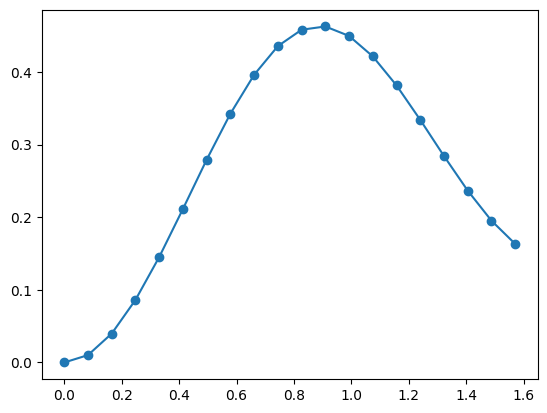

In [5]:
timestep=np.linspace(0, np.pi / 2, 20)
results_list = []
for t in timestep:
    qs = schwinger(N=N, T=t)
    qtpp.compile(qs, initial_state=init, verbose=-1)
    qtpp.run(verbose=-1)
    results_list.append(qtpp.results())
draw_results(timestep, results_list)

Next, we create an IonQ provider and run the simulation. The initial state $|0101\rangle$ is prepared with 2 X gates.

In [6]:
from simuq.ionq import IonQProvider

ionqp = IonQProvider(from_file="../../ionq_API_key")

In [7]:
def x_gate(q):
    gate = {"gate": "gpi", "target": q, "phase": 0.}
    return gate
state_prep = {"circuit": [x_gate(1), x_gate(3)]}

The experiment in \[1\] is conducted with total Trotter number $4$ on a laboratory device, and evaluates the particle number density after applying each Trotter step. We reproduce it on IonQ devices with the following code. Here we submit all jobs sequentially, and retrieve the results later.

In [8]:
num_step = 4
timestep = np.linspace(0, np.pi/2, num_step + 1)
job_list = []
for step, t in enumerate(timestep[1:]):
    walk = schwinger(N, t)
    ionqp.compile(walk, backend="aria-1", trotter_num=step + 1, state_prep=state_prep, verbose = -1)
    job_list.append(ionqp.run(shots=128, on_simulator=True, with_noise=False, verbose=-1))

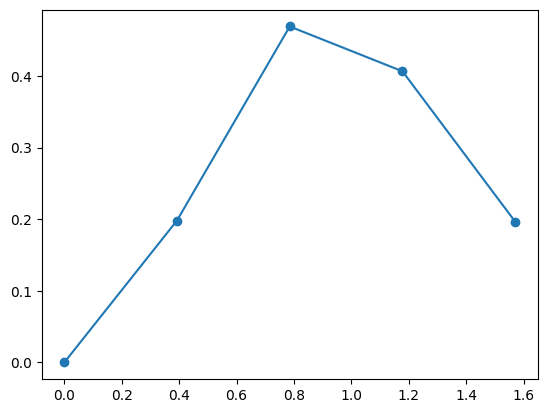

In [9]:
import time

def draw_with_ionq_jobs(job_list):
    results_list = [{'0101':1}]
    for job in job_list:
        while True:
            res = ionqp.results(job['id'], verbose=-1)
            if res is not None:
                break
            time.sleep(1)
        results_list.append(res)
    draw_results(timestep, results_list)

draw_with_ionq_jobs(job_list)

Now we send it to the IonQ Aria-2 to execute. It may take a while to queue, so we record the job ids here in the notebook.

In [10]:
num_step = 4
timestep=np.linspace(0, np.pi/2, num_step + 1)
job_list = []
for step, t in enumerate(timestep[1:]):
    walk = schwinger(N, t)
    ionqp.compile(walk, backend="aria-1", trotter_num=step + 1, state_prep=state_prep, verbose = -1)
    job_list.append(ionqp.run(shots=256, on_simulator=True, with_noise=True, verbose=-1))
print(job_list)

[{'id': 'a2ee2402-30fc-4c22-8f2f-43af4fbed708', 'status': 'ready', 'request': 1694596115}, {'id': '6d520a3a-d4cc-4af9-8949-1295ef555453', 'status': 'ready', 'request': 1694596116}, {'id': '78ba0f84-efb3-44dc-a9e5-354f4b146cbd', 'status': 'ready', 'request': 1694596116}, {'id': '318e1cd3-dc5a-426f-b00a-b354936b9007', 'status': 'ready', 'request': 1694596116}]


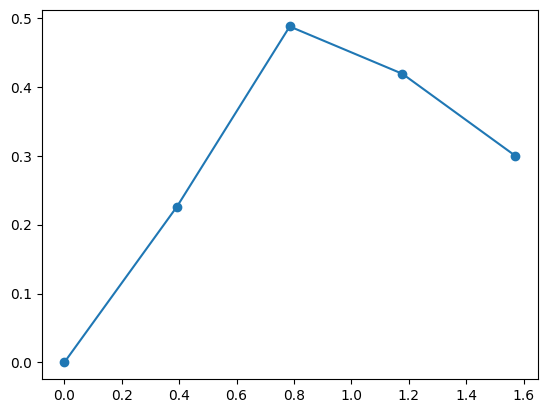

In [11]:
draw_with_ionq_jobs(job_list)

We may also reproduce Fig. 2 b and c from \[1\] following the similar ideas. These reproductions are left as practices.